In [2]:
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("/Users/CalebPitts/Documents/Files/Projects/TrafficVolume/interstate_traffic_data.csv")

In [4]:
df.shape

(48204, 9)

In [5]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


## Initial Data Cleansing

In [6]:
df["date_time"] = pd.to_datetime(df["date_time"])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
holiday                48204 non-null object
temp                   48204 non-null float64
rain_1h                48204 non-null float64
snow_1h                48204 non-null float64
clouds_all             48204 non-null int64
weather_main           48204 non-null object
weather_description    48204 non-null object
date_time              48204 non-null datetime64[ns]
traffic_volume         48204 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 3.3+ MB


In [8]:
df[df.isnull().any(axis=1)]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume


No null values in any of the rows. 

In [53]:
df["holiday"].value_counts()

None                         48143
Labor Day                        7
New Years Day                    6
Martin Luther King Jr Day        6
Christmas Day                    6
Thanksgiving Day                 6
Columbus Day                     5
Washingtons Birthday             5
Memorial Day                     5
Independence Day                 5
State Fair                       5
Veterans Day                     5
Name: holiday, dtype: int64

In [56]:
# converting holiday to binary value. 1 if holiday, 0 otherwise
df["holiday"] = df["holiday"].apply(lambda x: 0 if x == "None" else 1)
df["holiday"].value_counts()

0    48143
1       61
Name: holiday, dtype: int64

In [78]:
# determining quality of timestamp intervals
def get_timestamp_diffs(df):
    timestamp_diffs = df["date_time"].diff()
    print(timestamp_diffs.value_counts())

Looks like most times are 1 hour apart but there are some issues with duplicate rows, missing timestamps and a large gap of 307 days somewhere.

In [59]:
df = df.sort_values("date_time")
dups = df[df["date_time"].duplicated(keep=False)]
dups.head(10)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
178,0,281.25,0.0,0.0,99,Rain,light rain,2012-10-10 07:00:00,6793
179,0,281.25,0.0,0.0,99,Drizzle,light intensity drizzle,2012-10-10 07:00:00,6793
180,0,280.10,0.0,0.0,99,Rain,light rain,2012-10-10 08:00:00,6283
181,0,280.10,0.0,0.0,99,Drizzle,light intensity drizzle,2012-10-10 08:00:00,6283
182,0,279.61,0.0,0.0,99,Rain,light rain,2012-10-10 09:00:00,5680
183,0,279.61,0.0,0.0,99,Drizzle,light intensity drizzle,2012-10-10 09:00:00,5680
269,0,282.43,0.0,0.0,57,Drizzle,light intensity drizzle,2012-10-14 09:00:00,2685
270,0,282.43,0.0,0.0,57,Mist,mist,2012-10-14 09:00:00,2685
271,0,282.43,0.0,0.0,57,Haze,haze,2012-10-14 09:00:00,2685
272,0,282.33,0.0,0.0,57,Drizzle,light intensity drizzle,2012-10-14 10:00:00,3370


In [60]:
aggs = {"holiday": "sum",
        "temp": "mean",
        "rain_1h": "mean",
        "snow_1h": "mean", 
        "clouds_all": "mean",
        "weather_main": ', '.join,
        "weather_description": ', '.join,
        "traffic_volume": "mean"}

In [74]:
fixed_dups = dups.groupby("date_time").agg(aggs).reset_index()
non_dups = df[~df["date_time"].duplicated(keep=False)]  # select non duplicated rows
df_clean = non_dups.append(fixed_dups).sort_values("date_time")  # add fixed duplicated rows back to non duplicated rows

In [79]:
get_timestamp_diffs(df_clean)

0 days 01:00:00      37986
0 days 02:00:00       2192
0 days 03:00:00        201
0 days 04:00:00         59
0 days 05:00:00         33
0 days 06:00:00         17
0 days 10:00:00         13
0 days 08:00:00         13
0 days 09:00:00         12
0 days 07:00:00         10
1 days 00:00:00          4
0 days 22:00:00          4
0 days 11:00:00          4
0 days 13:00:00          3
0 days 14:00:00          3
0 days 12:00:00          2
1 days 06:00:00          2
0 days 15:00:00          2
0 days 21:00:00          2
0 days 18:00:00          1
1 days 23:00:00          1
1 days 01:00:00          1
10 days 03:00:00         1
1 days 10:00:00          1
1 days 09:00:00          1
4 days 21:00:00          1
3 days 21:00:00          1
0 days 17:00:00          1
2 days 17:00:00          1
307 days 19:00:00        1
4 days 22:00:00          1
Name: date_time, dtype: int64


In [83]:
df_clean[df_clean["date_time"].duplicated(keep=False)].shape

(0, 9)

I've now removed all duplicated rows since there are no timestamps that are the same anymore.

In [89]:
df_clean = df_clean.set_index("date_time").resample("H").first().fillna(-1)

In [90]:
df_clean.index.freq = 'H'

In [93]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52551 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Freq: H
Data columns (total 8 columns):
clouds_all             52551 non-null float64
holiday                52551 non-null float64
rain_1h                52551 non-null float64
snow_1h                52551 non-null float64
temp                   52551 non-null float64
traffic_volume         52551 non-null float64
weather_description    52551 non-null object
weather_main           52551 non-null object
dtypes: float64(6), object(2)
memory usage: 3.6+ MB


In [98]:
dfd.index

DatetimeIndex(['2012-10-02 09:00:00', '2012-10-02 10:00:00',
               '2012-10-02 11:00:00', '2012-10-02 12:00:00',
               '2012-10-02 13:00:00', '2012-10-02 14:00:00',
               '2012-10-02 15:00:00', '2012-10-02 16:00:00',
               '2012-10-02 17:00:00', '2012-10-02 18:00:00',
               ...
               '2018-09-30 15:00:00', '2018-09-30 15:00:00',
               '2018-09-30 16:00:00', '2018-09-30 17:00:00',
               '2018-09-30 18:00:00', '2018-09-30 19:00:00',
               '2018-09-30 20:00:00', '2018-09-30 21:00:00',
               '2018-09-30 22:00:00', '2018-09-30 23:00:00'],
              dtype='datetime64[ns]', name='date_time', length=48204, freq=None)

## Initial Data Exploration

In [20]:
df["traffic_volume"].describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

Average traffic volume in a given hour along the interstate is about **3260 cars.**

In [21]:
# grouping data by hour in the day 1-24 to see what an average day looks like
day_hourly_avgs = df.groupby(df.date_time.dt.hour).mean()

In [22]:
day_hourly_avgs

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
date_time,,,,,
0,279.913220,0.132857,0.000245,43.585174,834.781051
1,279.533744,0.119170,0.000298,43.160078,516.449000
2,279.349856,0.119302,0.000000,42.950966,388.353640
3,278.939843,0.165442,0.000079,42.518519,371.090864
4,278.510970,0.143826,0.000048,44.784314,702.551889
5,278.532218,0.170165,0.000048,44.411052,2094.573437
6,278.341978,0.194720,0.000048,45.343555,4140.503594
7,278.497823,0.187648,0.000048,50.384319,4740.181337
8,278.661342,0.127034,0.000120,52.280288,4587.497115


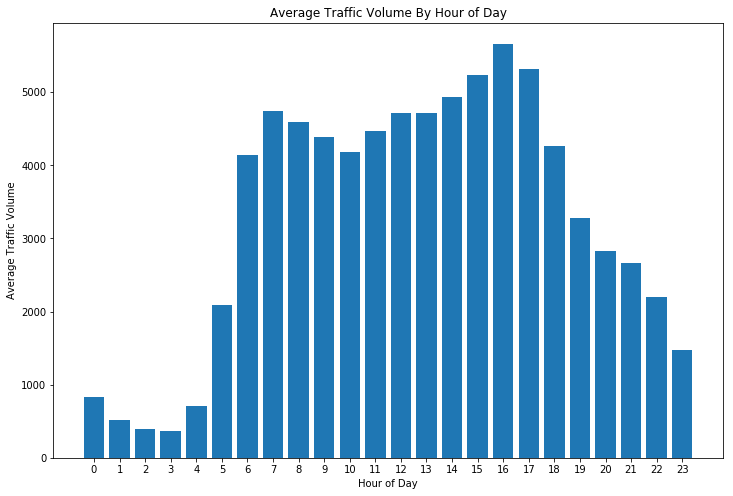

In [23]:
plt.figure(figsize=(12,8))
plt.bar(day_hourly_avgs.index, day_hourly_avgs["traffic_volume"])
plt.xticks([hour for hour in range(24)])
plt.title("Average Traffic Volume By Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Traffic Volume");

The bar chart gives an expected volume distribution with the lower volumes being night time 12-3AM and the peak volumes being 6-10AM and 3-5PM.

In [24]:
# grouping traffic volumes by day to see total volumes by day in the date series.
day_volumes = df.groupby(df.date_time.dt.date).sum()

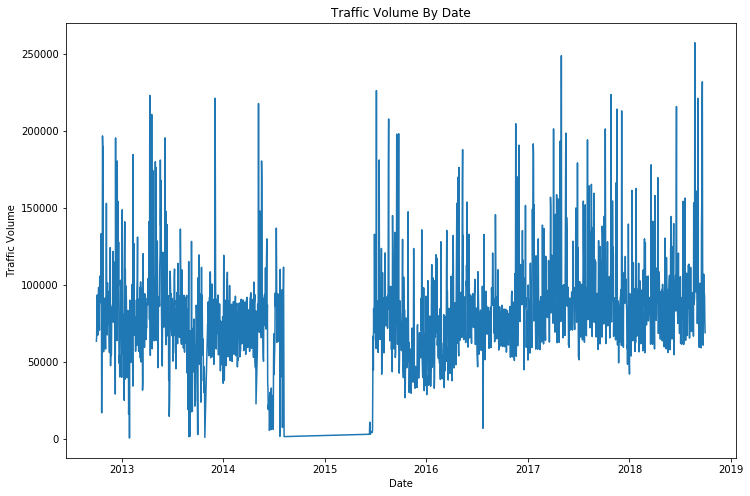

In [26]:
plt.figure(figsize=(12,8))
plt.plot(day_volumes.index, day_volumes["traffic_volume"])
plt.title("Traffic Volume By Date")
plt.xlabel("Date")
plt.ylabel("Traffic Volume");

Seems a little busy. Let's clean this up by creating a moving average and exploring the apparent gap in 2014/2015 data.

In [80]:
day_volumes["traffic_volume_r7"] = day_volumes["traffic_volume"].rolling(window=28).mean()

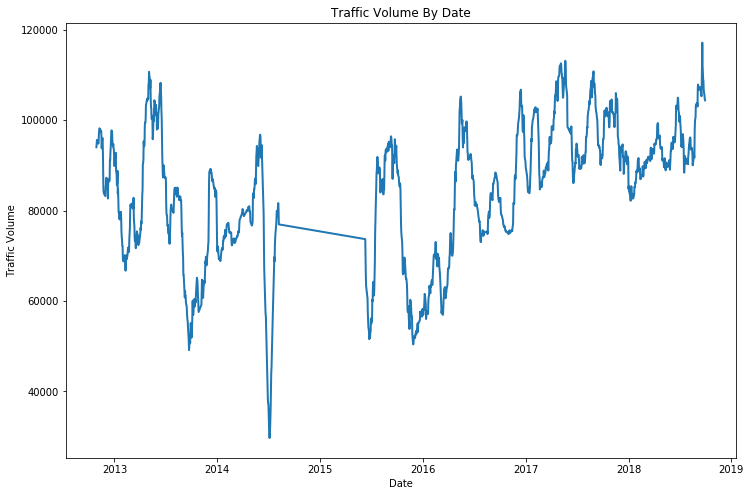

In [81]:
plt.figure(figsize=(12,8))
plt.plot(day_volumes.index, day_volumes["traffic_volume_r7"], lw=2)
plt.title("Traffic Volume By Date")
plt.xlabel("Date")
plt.ylabel("Traffic Volume");

In [90]:
df[(df["date_time"] > "2014-08-01") & (df["date_time"] < "2015-06-21")]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
15836,None,291.160,0.00,0.0,1,Clear,sky is clear,2014-08-01 01:00:00,521
15837,None,290.730,0.25,0.0,1,Rain,light rain,2014-08-01 02:00:00,380
15838,None,289.610,0.00,0.0,1,Mist,mist,2014-08-01 04:00:00,890
15839,None,289.350,0.00,0.0,1,Mist,mist,2014-08-01 05:00:00,2958
15840,None,289.270,0.00,0.0,1,Mist,mist,2014-08-01 06:00:00,5515
15841,None,289.470,0.00,0.0,1,Mist,mist,2014-08-01 07:00:00,6479
15842,None,291.720,0.00,0.0,1,Mist,mist,2014-08-01 08:00:00,5787
15843,None,293.620,0.00,0.0,5,Clear,sky is clear,2014-08-01 09:00:00,5363
15844,None,298.890,0.00,0.0,1,Clear,sky is clear,2014-08-01 11:00:00,5764
15845,None,299.920,0.00,0.0,75,Clouds,broken clouds,2014-08-01 12:00:00,5909


## Feature Engineering

Going to encode holidays with binary value. Also going to perform one-hot encoding for both weather_main and weather_description attributes.

In [15]:
df["holiday"].unique()

array(['None', 'Columbus Day', 'Veterans Day', 'Thanksgiving Day',
       'Christmas Day', 'New Years Day', 'Washingtons Birthday',
       'Memorial Day', 'Independence Day', 'State Fair', 'Labor Day',
       'Martin Luther King Jr Day'], dtype=object)

In [16]:
df["weather_main"].unique()

array(['Clouds', 'Clear', 'Rain', 'Drizzle', 'Mist', 'Haze', 'Fog',
       'Thunderstorm', 'Snow', 'Squall', 'Smoke'], dtype=object)

In [14]:
df["weather_description"].unique()

array(['scattered clouds', 'broken clouds', 'overcast clouds',
       'sky is clear', 'few clouds', 'light rain',
       'light intensity drizzle', 'mist', 'haze', 'fog',
       'proximity shower rain', 'drizzle', 'moderate rain',
       'heavy intensity rain', 'proximity thunderstorm',
       'thunderstorm with light rain', 'proximity thunderstorm with rain',
       'heavy snow', 'heavy intensity drizzle', 'snow',
       'thunderstorm with heavy rain', 'freezing rain', 'shower snow',
       'light rain and snow', 'light intensity shower rain', 'SQUALLS',
       'thunderstorm with rain', 'proximity thunderstorm with drizzle',
       'thunderstorm', 'Sky is Clear', 'very heavy rain',
       'thunderstorm with light drizzle', 'light snow',
       'thunderstorm with drizzle', 'smoke', 'shower drizzle',
       'light shower snow', 'sleet'], dtype=object)

In [67]:
# ALSO ADD SEASON 1,2,3,4 decided by the date